In [17]:
import pathlib
import shutil
# from multiprocessing import Pool, current_process

import random
import math 
from tqdm.autonotebook import tqdm
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
import platform

         
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline
mpl.rcParams['figure.dpi']= 120

plt.rcParams.update({'figure.max_open_warning': 0})
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.float_format', '{:,.5f}'.format)
pd.set_option('display.max_colwidth', 80)

_platform = platform.platform()
print('platform:', _platform, platform.node())
if 'Linux' in _platform: # linux
    rat_path = '/home/ece/rat_data/'
    tsn_path = '/home/ece/tsn_data/'
    
elif 'macOS' in _platform: # MAC OS X
    rat_path = '/Users/cclee/rat_data/'
    tsn_path = '/Users/cclee/tsn_data/'     
elif 'Windows' in _platform: # Windows
    if platform.node()=='Mozart':
        rat_path = 'e:/rat_data/'
        tsn_path = 'e:/tsn_data/' 
    else:
        rat_path = 'd:/rat_data/'   
        tsn_path = 'd:/tsn_data/' 
  
path_rat = pathlib.Path(rat_path)
path_tsn = pathlib.Path(tsn_path)

platform: Windows-10-10.0.18362-SP0 Mozart


In [18]:
df_rgb = pd.read_csv('test_rgb_resnet50_adam_1022_2344.csv', index_col= 0)
df_flow = pd.read_csv('test_flow_resnet50_adam_1022_2344.csv', index_col= 0)

print(df_rgb)
print(df_flow)

                                  clip  target  pred
0        Grooming_930217_L00480_000024       1     1
1        Grooming_930217_L00515_000025       1     1
2        Grooming_930217_L00865_000043       1     1
3        Grooming_930217_L00980_000049       1     1
4        Grooming_930217_L04250_000332       1     1
...                                ...     ...   ...
3030  Nongrooming_930219_R81940_010817       0     0
3031  Nongrooming_930219_R82245_010832       0     0
3032  Nongrooming_930219_R82630_010851       0     0
3033  Nongrooming_930219_R82705_010855       0     0
3034  Nongrooming_930219_R82875_010903       0     0

[3035 rows x 3 columns]
                                  clip  target  pred
0        Grooming_930217_L00480_000024       1     1
1        Grooming_930217_L00515_000025       1     1
2        Grooming_930217_L00865_000043       1     0
3        Grooming_930217_L00980_000049       1     0
4        Grooming_930217_L04250_000332       1     0
...                  

                                  clip  target_x  pred_x  pred_y
0        Grooming_930217_L00480_000024         1       1       1
1        Grooming_930217_L00515_000025         1       1       1
2        Grooming_930217_L00865_000043         1       1       0
3        Grooming_930217_L00980_000049         1       1       0
4        Grooming_930217_L04250_000332         1       1       0
...                                ...       ...     ...     ...
3030  Nongrooming_930219_R81940_010817         0       0       0
3031  Nongrooming_930219_R82245_010832         0       0       0
3032  Nongrooming_930219_R82630_010851         0       0       0
3033  Nongrooming_930219_R82705_010855         0       0       0
3034  Nongrooming_930219_R82875_010903         0       0       0

[3035 rows x 4 columns]
                                  clip  target_x  pred_x  pred_y  pred  diff
0        Grooming_930217_L00480_000024         1       1       1     1     0
1        Grooming_930217_L00515_000025   

Text(44.49999999999999, 0.5, 'true label')

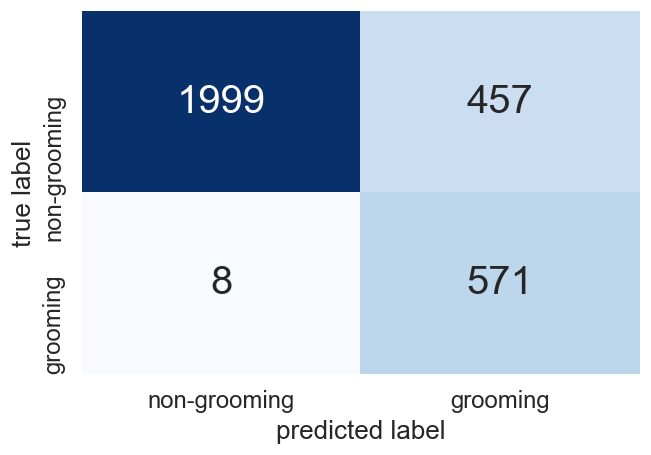

In [19]:
df1 = pd.merge(df_rgb, df_flow, left_on="clip", right_on="clip").drop('target_y', axis=1)
print(df1)
df1['pred'] = df1['pred_x'] | df1['pred_y']
df1['diff'] = abs(df1['target_x'] - df1['pred'])
print(df1)

conf_mx = confusion_matrix(df1['target_x'], df1['pred'])
print(conf_mx)
labels = ['non-grooming', 'grooming']
sns.set(style="whitegrid", font_scale=1.3)
ax = sns.heatmap(conf_mx,annot=True,cmap="Blues",fmt="d",cbar=False,annot_kws={"size": 24}, xticklabels=labels, yticklabels=labels);
ax.set_xlabel('predicted label')
ax.set_ylabel('true label')

# process misclassified

In [20]:
err_mask = df1['diff']==1
df_err = df1[err_mask]
print(df_err)
print('acc=', 1-len(df_err)/len(df1))
df_err.to_csv('misclassified.csv')

df_err['clip_name'] = df_err['clip'].apply(lambda x: x.split('_',1)[-1])
df_err['grooming'] = df_err['clip'].apply(lambda x: x[0]=='G')
display(df_err)

df_mis_groom_FN = df_err[df_err['grooming']==True]
mis_groom_FN_lst = list(df_mis_groom_FN['clip_name'])
print('mis_groom_FN_lst', len(mis_groom_FN_lst))

df_mis_nongroom_FP = df_err[df_err['grooming']==False]
mis_nongroom_FP_lst = list(df_mis_nongroom_FP['clip_name'])
print('mis_nongroom_FP_lst', len(mis_nongroom_FP_lst))

                                  clip  target_x  pred_x  pred_y  pred  diff
51       Grooming_930217_L47005_003910         1       0       0     0     1
218      Grooming_930218_L27280_002244         1       0       0     0     1
220      Grooming_930218_L31480_002614         1       0       0     0     1
266      Grooming_930218_L55005_004550         1       0       0     0     1
271      Grooming_930218_L57260_004743         1       0       0     0     1
...                                ...       ...     ...     ...   ...   ...
2954  Nongrooming_930219_R71320_005926         0       1       0     1     1
2955  Nongrooming_930219_R71360_005928         0       0       1     1     1
2971  Nongrooming_930219_R73735_010126         0       1       1     1     1
2987  Nongrooming_930219_R75255_010242         0       0       1     1     1
3013  Nongrooming_930219_R78565_010528         0       0       1     1     1

[465 rows x 6 columns]
acc= 0.8467874794069192


<ipython-input-20-891de777459e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_err['clip_name'] = df_err['clip'].apply(lambda x: x.split('_',1)[-1])
<ipython-input-20-891de777459e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_err['grooming'] = df_err['clip'].apply(lambda x: x[0]=='G')


,clip,target_x,pred_x,pred_y,pred,diff,clip_name,grooming
51,Grooming_930217_L47005_003910,1,0,0,0,1,930217_L47005_003910,True
218,Grooming_930218_L27280_002244,1,0,0,0,1,930218_L27280_002244,True
220,Grooming_930218_L31480_002614,1,0,0,0,1,930218_L31480_002614,True
266,Grooming_930218_L55005_004550,1,0,0,0,1,930218_L55005_004550,True
271,Grooming_930218_L57260_004743,1,0,0,0,1,930218_L57260_004743,True
...,...,...,...,...,...,...,...,...
2954,Nongrooming_930219_R71320_005926,0,1,0,1,1,930219_R71320_005926,False
2955,Nongrooming_930219_R71360_005928,0,0,1,1,1,930219_R71360_005928,False
2971,Nongrooming_930219_R73735_010126,0,1,1,1,1,930219_R73735_010126,False
2987,Nongrooming_930219_R75255_010242,0,0,1,1,1,930219_R75255_010242,False


mis_groom_FN_lst 8
mis_nongroom_FP_lst 457


# process correct classification

In [21]:
corr_mask = df1['diff']==0
df_corr = df1[corr_mask]
print(df_corr)
print('acc=', len(df_corr)/len(df1))
df_corr.to_csv('corr_classified.csv')

df_corr['clip_name'] = df_corr['clip'].apply(lambda x: x.split('_',1)[-1])
df_corr['grooming'] = df_corr['clip'].apply(lambda x: x[0]=='G')
display(df_corr)

df_groom_TP = df_corr[df_corr['grooming']==True]
groom_TP_lst = list(df_groom_TP['clip_name'])
print('groom_TP_lst', len(groom_TP_lst))

df_nongroom_TN = df_corr[df_corr['grooming']==False]
nongroom_TN_lst = list(df_nongroom_TN['clip_name'])
print('nongroom_TN_lst', len(nongroom_TN_lst))

                                  clip  target_x  pred_x  pred_y  pred  diff
0        Grooming_930217_L00480_000024         1       1       1     1     0
1        Grooming_930217_L00515_000025         1       1       1     1     0
2        Grooming_930217_L00865_000043         1       1       0     1     0
3        Grooming_930217_L00980_000049         1       1       0     1     0
4        Grooming_930217_L04250_000332         1       1       0     1     0
...                                ...       ...     ...     ...   ...   ...
3030  Nongrooming_930219_R81940_010817         0       0       0     0     0
3031  Nongrooming_930219_R82245_010832         0       0       0     0     0
3032  Nongrooming_930219_R82630_010851         0       0       0     0     0
3033  Nongrooming_930219_R82705_010855         0       0       0     0     0
3034  Nongrooming_930219_R82875_010903         0       0       0     0     0

[2570 rows x 6 columns]
acc= 0.8467874794069192


<ipython-input-21-88eeb50782b0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['clip_name'] = df_corr['clip'].apply(lambda x: x.split('_',1)[-1])
<ipython-input-21-88eeb50782b0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['grooming'] = df_corr['clip'].apply(lambda x: x[0]=='G')


,clip,target_x,pred_x,pred_y,pred,diff,clip_name,grooming
0,Grooming_930217_L00480_000024,1,1,1,1,0,930217_L00480_000024,True
1,Grooming_930217_L00515_000025,1,1,1,1,0,930217_L00515_000025,True
2,Grooming_930217_L00865_000043,1,1,0,1,0,930217_L00865_000043,True
3,Grooming_930217_L00980_000049,1,1,0,1,0,930217_L00980_000049,True
4,Grooming_930217_L04250_000332,1,1,0,1,0,930217_L04250_000332,True
...,...,...,...,...,...,...,...,...
3030,Nongrooming_930219_R81940_010817,0,0,0,0,0,930219_R81940_010817,False
3031,Nongrooming_930219_R82245_010832,0,0,0,0,0,930219_R82245_010832,False
3032,Nongrooming_930219_R82630_010851,0,0,0,0,0,930219_R82630_010851,False
3033,Nongrooming_930219_R82705_010855,0,0,0,0,0,930219_R82705_010855,False


groom_TP_lst 571
nongroom_TN_lst 1999


In [22]:
fontFace = cv2.FONT_HERSHEY_SIMPLEX
_black = (0, 0, 0) 
_white = (255, 255, 255)
font_color = (0,255,0)

def stitch_video(mp4_lst, prefix, out_path):
    video_file = str(mp4_lst[0])
    cap = cv2.VideoCapture(video_file)
    bOpenVideo = cap.isOpened()
    if bOpenVideo == False:
        print('Open Video failed ', mp4_lst[0])
        return

    video_fps = cap.get(cv2.CAP_PROP_FPS) *2 #20
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    outName = '{}/{:s}.mp4'.format(str(out_path.parent), prefix) 
    vidw = cv2.VideoWriter(outName, cv2.VideoWriter_fourcc(*'avc1'),  ####XVID'), 
                           video_fps, (width, height), True)  # Make a video

    if vidw.isOpened()==True:
        pbar = tqdm(total=len(mp4_lst))
        for i, clip in enumerate(mp4_lst):
            shutil.copyfile(clip, out_path.joinpath(clip.name))
            
            cap = cv2.VideoCapture(str(clip))
            bOpenVideo = cap.isOpened()
            if bOpenVideo == False:
                print('Open Video failed ', str(clip))
                continue            
            
            w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            resize = False
            if w!=width or h!=height:
                resize = True
                
            title_str = clip.stem.rsplit('_', 1)[0]
            k = 0
            while True:
                bVideoRead, frame = cap.read()
                if bVideoRead:
                    if resize:
                        dim = (width, height)
                        frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
                        
                    cv2.putText(frame, title_str, (5,frame.shape[0]-10), fontFace, 0.5, font_color)
                    vidw.write(frame)
                    k+= 1
                else:                                        
                    break
                    
            pbar.update(1)
#             print(i, clip.name, k)
        vidw.release()  
        print('out video: ', outName)
    else:
        print('ERROR: output video, ' , outName)
    
    print('stitch_video finished, video_fps ', video_fps)

In [23]:
date_lst = ['930217', '930218', '930219']
ddir = [x for x in path_rat.iterdir() if x.is_dir() and x.name.split('-')[0] in date_lst]
ddir = sorted(ddir)
print(ddir)

outpath_fp = path_tsn.joinpath('{}'.format(date_lst[0]), 'fp')
outpath_fn = path_tsn.joinpath('{}'.format(date_lst[0]), 'fn')

outpath_tp = path_tsn.joinpath('{}'.format(date_lst[0]), 'tp')
outpath_tn = path_tsn.joinpath('{}'.format(date_lst[0]), 'tn')

if outpath_fp.exists():
    shutil.rmtree(str(outpath_fp))
outpath_fp.mkdir() 

if outpath_fn.exists():
    shutil.rmtree(str(outpath_fn))
outpath_fn.mkdir() 
   
if outpath_tp.exists():
    shutil.rmtree(str(outpath_tp))
outpath_tp.mkdir() 

if outpath_tn.exists():
    shutil.rmtree(str(outpath_tn))
outpath_tn.mkdir() 

mp4_lst = []
for dd in ddir:
    lst = sorted(dd.glob('*.mp4'))
    mp4_lst.extend(lst)
    
# print(len(mp4_lst))
# print(mp4_lst[0].stem.split('.', 1)[0])
mp4_mis = [x for x in mp4_lst if x.stem.split('.', 1)[0] in mis_groom_FN_lst]
print('find fn clips ', len(mp4_mis))
stitch_video(mp4_mis, '930217_mis_groom_FN', outpath_fn)

mp4_mis = [x for x in mp4_lst if x.stem.split('.', 1)[0] in mis_nongroom_FP_lst]
print('find fp clips ', len(mp4_mis))
stitch_video(mp4_mis, '930217_mis_nongroom_FP', outpath_fp)

mp4_mis = [x for x in mp4_lst if x.stem.split('.', 1)[0] in groom_TP_lst]
print('find groom_TP clips ', len(mp4_mis))
stitch_video(mp4_mis, '930217_groom_TP', outpath_tp)

mp4_mis = [x for x in mp4_lst if x.stem.split('.', 1)[0] in nongroom_TN_lst]
print('find nongroom_TN clips ', len(mp4_mis))
stitch_video(mp4_mis, '930217_nongroom_TN', outpath_tn)

[WindowsPath('e:/rat_data/930217-base-1d'), WindowsPath('e:/rat_data/930218-base-2d'), WindowsPath('e:/rat_data/930219-B-car-3-1d')]
find fn clips  8


out video:  e:\tsn_data\930217/930217_mis_groom_FN.mp4
stitch_video finished, video_fps  20.0
find fp clips  457


out video:  e:\tsn_data\930217/930217_mis_nongroom_FP.mp4
stitch_video finished, video_fps  20.0
find groom_TP clips  571


out video:  e:\tsn_data\930217/930217_groom_TP.mp4
stitch_video finished, video_fps  20.0
find nongroom_TN clips  1999


out video:  e:\tsn_data\930217/930217_nongroom_TN.mp4
stitch_video finished, video_fps  20.0
